[![GitHub Repo stars](https://img.shields.io/github/stars/speechbrain/speechbrain?style=social) *Please, help our community project. Star on GitHub!*](https://github.com/speechbrain/speechbrain)

# **Federated Speech Model Training via Flower and SpeechBrain**


Are you interested in both federated learning (FL) and speech, but worried about the proper tools to run experiments? Today you will get the answer. This tutorial introduces how to integrate [Flower](https://github.com/adap/flower) and [SpeechBrain](https://github.com/speechbrain/speechbrain) to achieve federated speech model training.

**Important:** It is recommended to be familiar with SpeechBrain and Flower before jumping into this tutorial as some parts may involve some level of complexity. Tutorials are available for both toolkits on their respective website!

For simplicity, we choose a popular speech task --- automatic speech recognition (ASR) as an example, and training will be done with a toy dataset which only contains 100 audio recordings. In a real case, you need much more training data (e.g 100 or even 1000 hours) to reach acceptable performance. Note that ASR is regarded as a case study, all other speech related tasks can be done similarly.

Apart from running normal federated ASR model training, the code also provides three other features to speed up model converge and improve the performance.

* Loading a centralised initial model before federated training starts.

* Providing three aggregation weighting strategies --- stardard FedAvg, Loss-based and WER-based aggregation based on [this paper](https://arxiv.org/abs/2104.14297).

* Facilitating an additional training with a held-out dataset on the server side after aggregation.

The details of them will be elaborated in the later sections.





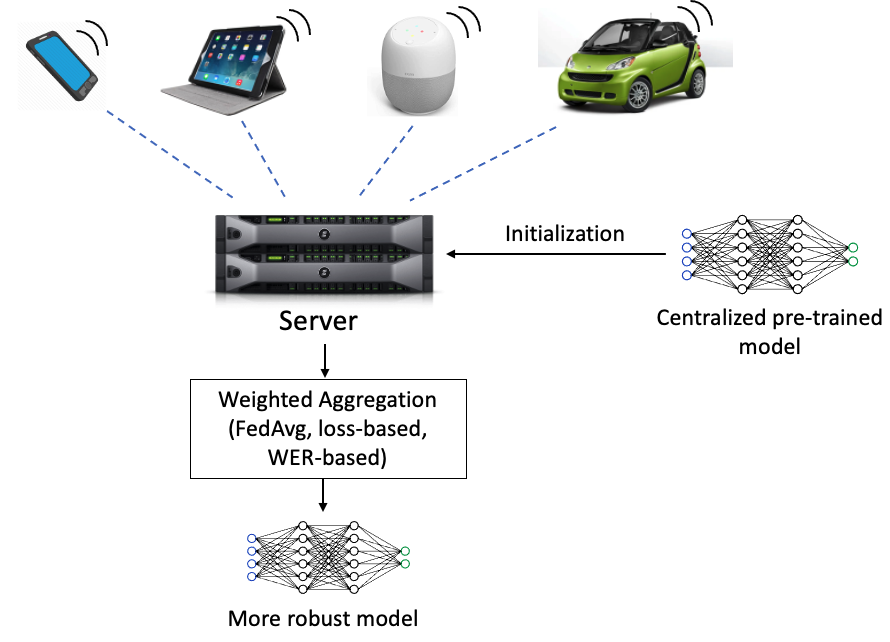

To run the code fast enough, we suggest using a GPU (`Runtime => change runtime type => GPU`).


## **Installation**
Before starting, let's install Flower and SpeechBrain:

In [ ]:
%%capture
# Installing SpeechBrain via pip
BRANCH = 'develop'
!python -m pip install git+https://github.com/speechbrain/speechbrain.git@$BRANCH

# Clone SpeechBrain repository
!git clone https://github.com/speechbrain/speechbrain/
%cd /content/speechbrain/

In [ ]:
%%capture
# For pip installation
!pip install flwr

# update tqdm package to avoid an ImportError.
!pip install tqdm==4.50.2

Then, download Flower-SpeechBrain integration code and template dataset, which was released on ```github.com/yan-gao-GY/Flower-SpeechBrain```. This integration will be explained in more details later on.

In [ ]:
%cd ..
%rm -rf Flower-SpeechBrain

In [ ]:
%rm -rf results

In [ ]:
%%capture
!git clone https://github.com/yan-gao-GY/Flower-SpeechBrain.git

## **What steps are needed for your experiments?**

The steps needed to launch a federated speech model training are just as normal Flower experiments.

1. **Prepare your data**. The goal of this step is to create the data manifest files (TSV format) to fit the input format of SpeechBrain. The data manifest files contains the location of the speech data and their corresponding text annotations. In this tutorial, we skip the data partitioning step and simulate different partitions using a small template dataset. But in practice, you might want to have different files per federated client or a more complex data partitioning scheme.

Now let's uncompress our template dataset.

In [ ]:
%cd /content/Flower-SpeechBrain/temp_dataset/
import zipfile
import os

# Uncompression function
def un_zip(file_name):
  zip_file = zipfile.ZipFile(file_name)
  for names in zip_file.namelist():
    zip_file.extract(names)
  zip_file.close()

un_zip("temp_dataset.zip")

# Simulate partitions using template dataset.
%cp temp_dataset.tsv train_0.tsv

# Go back to /content directory.
%cd /content

2. **Specify server and clients**. As Colab notebooks only allow one cell to be run at a time, we simulate the server and the clients as background processes within this tutorial. The following cells create `server.sh` and `clients.sh` scripts that will launch the required processes. All arguments required for federated training are passed in from the scripts.

In [ ]:
%%writefile server.sh
PYTHONUNBUFFERED=1 python3 /content/Flower-SpeechBrain/server.py \
  --data_path="/content/Flower-SpeechBrain/temp_dataset/" \
  --config_path="/content/Flower-SpeechBrain/configs/" \
  --tr_path="/content/Flower-SpeechBrain/temp_dataset/temp_dataset.tsv" \
  --test_path="/content/Flower-SpeechBrain/temp_dataset/temp_dataset.tsv" \
  --tr_add_path="/content/Flower-SpeechBrain/temp_dataset/temp_dataset.tsv" \
  --config_file="template.yaml" \
  --min_fit_clients=1 \
  --min_available_clients=1 \
  --rounds=1 \
  --local_epochs=1 \
  --server_address="localhost:24338"

In [ ]:
%%writefile clients.sh
export PYTHONUNBUFFERED=1
NUM_CLIENTS=1


echo "Starting $NUM_CLIENTS clients."
for ((i = 0; i < $NUM_CLIENTS; i++))
do
    echo "Starting client(cid=$i) with partition $i out of $NUM_CLIENTS clients."
    # Staggered loading of clients: clients are loaded 8s apart.
    sleep 8s
    python3 /content/Flower-SpeechBrain/client.py \
      --cid=$i \
      --data_path="/content/Flower-SpeechBrain/temp_dataset/" \
      --tr_path="/content/Flower-SpeechBrain/temp_dataset/" \
      --dev_path="/content/Flower-SpeechBrain/temp_dataset/temp_dataset.tsv" \
      --config_path="/content/Flower-SpeechBrain/configs/" \
      --config_file="template.yaml" \
      --eval_device="cuda:0" \
      --server_address="localhost:24338" &
done
echo "Started $NUM_CLIENTS clients."

In [ ]:
# Execute this after running any of the %%writefile cells above
!chmod +x clients.sh server.sh

3. **Launch federated training~!** The following single cell will start the server, wait 5 seconds for it to initialise, and then start all clients.

  ```
  !((./server.sh & sleep 5s); ./clients.sh)
  ```

  We suggest running it at the end of this tutorial.


## **Integration details — coupling SpeechBrain to Flower**
Let's first see some details of the integration process to better understand the code. There are only four main steps required:

1. Define a Brain class ([SpeechBrain Brain Class tutorial](https://colab.research.google.com/drive/1fdqTk4CTXNcrcSVFvaOKzRfLmj4fJfwa?usp=sharing)).
2. Intialise the Brain class and dataset ([SpeechBrain dataio tutorial](https://colab.research.google.com/drive/1AiVJZhZKwEI4nFGANKXEe-ffZFfvXKwH?usp=sharing)).
3. Define a SpeechBrain Client ([Flower client documentation](https://flower.dev/docs/quickstart_pytorch.html#flower-client)).
4. Define a Flower Strategy on the server side ([Flower strategies](https://flower.dev/docs/strategies.html#strategies)).

### **Define a Brain class**

First, we define our customised Brain class as any normal SpeechBrain experiments. This override is necessary (while usually not needed on SpeechBrain) because Flower requires the number of processed samples to perform aggregation!

```python
class ASR(sb.core.Brain):
    def compute_forward(self, batch, stage):
      """Forward pass, to be overridden by sub-classes.

        Arguments
        ---------
        batch : torch.Tensor or tensors
            An element from the dataloader, including inputs for processing.
        stage : Stage
            The stage of the experiment: Stage.TRAIN, Stage.VALID, Stage.TEST

        Returns
        -------
        torch.Tensor or Tensors
            The outputs after all processing is complete.
            Directly passed to ``compute_objectives()``.
        """
      [...]

    def compute_objectives(self, predictions, batch, stage):
      """Compute loss, to be overridden by sub-classes.

        Arguments
        ---------
        predictions : torch.Tensor or Tensors
            The output tensor or tensors to evaluate.
            Comes directly from ``compute_forward()``.
        batch : torch.Tensor or tensors
            An element from the dataloader, including targets for comparison.
        stage : Stage
            The stage of the experiment: Stage.TRAIN, Stage.VALID, Stage.TEST

        Returns
        -------
        loss : torch.Tensor
            A tensor with the computed loss.
        """
      [...]

    def fit_batch(self, batch):
      """Fit one batch, override to do multiple updates.

        The default implementation depends on a few methods being defined
        with a particular behavior:

        * ``compute_forward()``
        * ``compute_objectives()``

        Also depends on having optimizers passed at initialization.

        Arguments
        ---------
        batch : list of torch.Tensors
            Batch of data to use for training. Default implementation assumes
            this batch has two elements: inputs and targets.

        Returns
        -------
        detached loss
        """
      [...]

    def evaluate_batch(self, batch, stage):
      """Evaluate one batch, override for different procedure than train.

        The default implementation depends on two methods being defined
        with a particular behavior:

        * ``compute_forward()``
        * ``compute_objectives()``

        Arguments
        ---------
        batch : list of torch.Tensors
            Batch of data to use for evaluation. Default implementation assumes
            this batch has two elements: inputs and targets.
        stage : Stage
            The stage of the experiment: Stage.VALID, Stage.TEST

        Returns
        -------
        detached loss
        """
      [...]

    def fit(
            self,
            epoch_counter,
            train_set,
            valid_set=None,
            progressbar=None,
            train_loader_kwargs={},
            valid_loader_kwargs={},
    ):
    """Iterate epochs and datasets to improve objective.

        Relies on the existence of multiple functions that can (or should) be
        overridden. The following methods are used and expected to have a
        certain behavior:

        * ``fit_batch()``
        * ``evaluate_batch()``
        * ``update_average()``

        If the initialization was done with distributed_count > 0 and the
        distributed_backend is ddp, this will generally handle multiprocess
        logic, like splitting the training data into subsets for each device and
        only saving a checkpoint on the main process.

        Arguments
        ---------
        epoch_counter : iterable
            Each call should return an integer indicating the epoch count.
        train_set : Dataset, DataLoader
            A set of data to use for training. If a Dataset is given, a
            DataLoader is automatically created. If a DataLoader is given, it is
            used directly.
        valid_set : Dataset, DataLoader
            A set of data to use for validation. If a Dataset is given, a
            DataLoader is automatically created. If a DataLoader is given, it is
            used directly.
        train_loader_kwargs : dict
            Kwargs passed to `make_dataloader()` for making the train_loader
            (if train_set is a Dataset, not DataLoader).
            E.G. batch_size, num_workers.
            DataLoader kwargs are all valid.
        valid_loader_kwargs : dict
            Kwargs passed to `make_dataloader()` for making the valid_loader
            (if valid_set is a Dataset, not DataLoader).
            E.g., batch_size, num_workers.
            DataLoader kwargs are all valid.
        progressbar : bool
            Whether to display the progress of each epoch in a progressbar.
        """
      [...]

     def evaluate(
        self,
        test_set,
        progressbar=None,
        test_loader_kwargs={},
    ):
    """Iterate test_set and evaluate brain performance. By default, loads
        the best-performing checkpoint (as recorded using the checkpointer).

        Arguments
        ---------
        test_set : Dataset, DataLoader
            If a DataLoader is given, it is iterated directly. Otherwise passed
            to ``self.make_dataloader()``.
        max_key : str
            Key to use for finding best checkpoint, passed to
            ``on_evaluate_start()``.
        min_key : str
            Key to use for finding best checkpoint, passed to
            ``on_evaluate_start()``.
        progressbar : bool
            Whether to display the progress in a progressbar.
        test_loader_kwargs : dict
            Kwargs passed to ``make_dataloader()`` if ``test_set`` is not a
            DataLoader. NOTE: ``loader_kwargs["ckpt_prefix"]`` gets
            automatically overwritten to ``None`` (so that the test DataLoader
            is not added to the checkpointer).

        Returns
        -------
        average test loss
        """
      [...]
```

We override the `fit()` method, which calculates number of training examples, average training loss and average WER. In practice, the code is almost identical to the official SpeechBrain (copy and paste), as we just need to return the number of processed samples !

```python
    def fit(
            self,
            epoch_counter,
            train_set,
            valid_set=None,
            progressbar=None,
            train_loader_kwargs={},
            valid_loader_kwargs={},
    ):
        # make dataloader for train and valid set
        if not isinstance(train_set, DataLoader):
            train_set = self.make_dataloader(
                train_set, stage=sb.Stage.TRAIN, **train_loader_kwargs
            )
        if valid_set is not None and not isinstance(valid_set, DataLoader):
            valid_set = self.make_dataloader(
                valid_set,
                stage=sb.Stage.VALID,
                ckpt_prefix=None,
                **valid_loader_kwargs,
            )

        self.on_fit_start()

        if progressbar is None:
            progressbar = not self.noprogressbar

        batch_count = 0
        # Iterate epochs
        for epoch in epoch_counter:

            # Training stage
            self.on_stage_start(sb.Stage.TRAIN, epoch)
            self.modules.train()
            avg_wer = 0.0

            # Reset nonfinite count to 0 each epoch
            self.nonfinite_count = 0

            if self.train_sampler is not None and hasattr(
                    self.train_sampler, "set_epoch"
            ):
                self.train_sampler.set_epoch(epoch)

            # Time since last intra-epoch checkpoint
            last_ckpt_time = time.time()

            # Only show progressbar if requested and main_process
            enable = progressbar and sb.utils.distributed.if_main_process()
            with tqdm(
                    train_set,
                    initial=self.step,
                    dynamic_ncols=True,
                    disable=not enable,
            ) as t:
                for batch in t:
                    self.step += 1
                    loss, wer = self.fit_batch(batch)

                    # calculate the number of training samples
                    _, wav_lens = batch.sig
                    batch_count += wav_lens.shape[0]

                    self.avg_train_loss = self.update_average(
                        loss, self.avg_train_loss
                    )
                    avg_wer = self.update_average_wer(
                        wer, avg_wer
                    )
                    t.set_postfix(train_loss=self.avg_train_loss)

                    # Debug mode only runs a few batches
                    if self.debug and self.step == self.debug_batches:
                        break

                    if (
                            self.checkpointer is not None
                            and self.ckpt_interval_minutes > 0
                            and time.time() - last_ckpt_time
                            >= self.ckpt_interval_minutes * 60.0
                    ):
                        run_on_main(self._save_intra_epoch_ckpt)
                        last_ckpt_time = time.time()

            # fetch the training loss from the last epoch
            if epoch == epoch_counter.limit:
                avg_loss = self.avg_train_loss

            # Run train "on_stage_end" on all processes
            self.on_stage_end(sb.Stage.TRAIN, self.avg_train_loss, epoch)
            self.avg_train_loss = 0.0
            self.step = 0

            # Validation stage
            if valid_set is not None:
                self.on_stage_start(sb.Stage.VALID, epoch)
                self.modules.eval()
                avg_valid_loss = 0.0
                with torch.no_grad():
                    for batch in tqdm(
                            valid_set, dynamic_ncols=True, disable=not enable
                    ):
                        self.step += 1
                        loss = self.evaluate_batch(batch, stage=sb.Stage.VALID)
                        avg_valid_loss = self.update_average(
                            loss, avg_valid_loss
                        )

                        # Debug mode only runs a few batches
                        if self.debug and self.step == self.debug_batches:
                            break

                    # Only run validation "on_stage_end" on main process
                    self.step = 0
                    valid_wer = self.on_stage_end(sb.Stage.VALID, avg_valid_loss, epoch)
                    # fetch the valid WER from the last epoch
                    if epoch == epoch_counter.limit:
                        valid_wer_last = valid_wer

            # Debug mode only runs a few epochs
            if self.debug and epoch == self.debug_epochs:
                break

        return batch_count, avg_loss, valid_wer_last

```


### **Initialise Brain class and dataset**
Next, we instanciate the `ASR` Brain class defined before, as well as the dataset. In SpeechBrain, this would be the `Main` function of your speech recipe. Here, we need to encapsulate this because Flower will call this function for each client of the federated setup to initialise it properly!

```python
def int_model(
    flower_path,
    tr_path,
    dev_path,
    test_path,
    save_path,
    data_path,
    config_file="CRDNN.yaml",
    tokenizer_path=None,
    eval_device="cuda:0",
    evaluate=False,
    add_train=False):

    # Load hyperparameters file with command-line overrides
    params_file = flower_path + config_file

    # Override with FLOWER PARAMS
    if evaluate:
        overrides = {
            "output_folder": save_path,
            "number_of_epochs": 1,
            "test_batch_size": 4,
            "device": eval_device,
        }
    elif add_train:
        overrides = {
            "output_folder": save_path,
            "lr": 0.01
        }

    else:
        overrides = {
            "output_folder": save_path
        }
    run_opts = None

    with open(params_file) as fin:
        params = load_hyperpyyaml(fin, overrides)

    params["data_folder"] = data_path
    params["train_tsv_file"] = tr_path
    params["dev_tsv_file"] = dev_path
    params["test_tsv_file"] = test_path
    params["save_folder"] = params["output_folder"] + "/save"
    params["train_csv"] = params["save_folder"] + "/train.csv"
    params["valid_csv"] = params["save_folder"] + "/dev.csv"
    params["test_csv"] = params["save_folder"] + "/test.csv"
    params["tokenizer_csv"] = tokenizer_path if tokenizer_path is not None else params["train_csv"]

    # Dataset preparation (parsing CommonVoice)
    from common_voice_prepare import prepare_common_voice  # noqa

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=params["output_folder"],
        hyperparams_to_save=params_file,
        overrides=overrides,
    )

    # Due to DDP, we do the preparation ONLY on the main python process
    run_on_main(
        prepare_common_voice,
        kwargs={
            "data_folder": params["data_folder"],
            "save_folder": params["save_folder"],
            "train_tsv_file": params["train_tsv_file"],
            "dev_tsv_file": params["dev_tsv_file"],
            "test_tsv_file": params["test_tsv_file"],
            "accented_letters": params["accented_letters"],
            "language": params["language"],
        },
    )

    # Create the datasets objects as well as tokenization and encoding :-D
    train_data, valid_data, test_data, tokenizer = dataio_prepare(params)

    # Trainer initialization
    asr_brain = ASR(
        modules=params["modules"],
        hparams=params,
        run_opts=run_opts,
        opt_class=params["opt_class"],
        checkpointer=params["checkpointer"],
    )

    # Adding objects to trainer.
    asr_brain.tokenizer = tokenizer

    return asr_brain, [train_data, valid_data, test_data]

asr_brain, dataset = int_model(...)
```
This function can also load all hyper-parameters from provided `yaml` file as normal SpeechBrain model training. Additionally, we can overwite the hyper-parameters of `yaml` file here.

### **Define a SpeechBrain client**
We define a customised Flower client that can mainly achieve three features:
* Set server weights to SpeechBrain model.
* Trigger SpeechBrain model training.
* Extract model weights after training.

Let's first see `set_weights` and `get_weights` functions. This is quite simple, just the transformation between pytorch tensor and NumPy ndarrays.

If you are familiar with SpeechBrain, you will recognize the **modules** argument. If not, this simply is all the PyTorch blocks of your pipeline. This means that we can iterated over the state_dict to obtain absolutely all the parameters of the speech pipeline.

```python
def set_weights(weights, modules, device) -> None:
    """Set model weights from a list of NumPy ndarrays."""
    state_dict = OrderedDict()
    valid_keys = [k for k in modules.state_dict().keys()]
    for k, v in zip(valid_keys, weights):
        v_ = torch.Tensor(np.array(v))
        v_ = v_.to(device)
        state_dict[k] = v_
    modules.load_state_dict(state_dict, strict=False)

def get_weights(modules):
    """Get model weights as a list of NumPy ndarrays."""
    w = []
    for k, v in modules.state_dict().items():
        w.append(v.cpu().numpy())
    return w
```

Then, we define the `SpeechBrainClient` class.

```python
class SpeechBrainClient(fl.client.NumPyClient):
    def __init__(self,
        cid: int,
        asr_brain,
        dataset,
        pre_train_model_path=None):

        self.cid = cid
        self.params = asr_brain.hparams
        self.modules = asr_brain.modules
        self.asr_brain = asr_brain
        self.dataset = dataset
        self.pre_train_model_path = pre_train_model_path


      def get_parameters(self, config):
        print(f"Client {self.cid}: get_parameters")
        weights = get_weights(self.modules)
        return weights


    def fit(self, parameters, config):
        print(f"Client {self.cid}: fit")

        # Read training configuration
        global_rounds = int(config["epoch_global"])
        print("Current global round: ", global_rounds)
        epochs = int(config["epochs"])

        (
            new_weights,
            num_examples,
            num_examples_ceil,
            fit_duration,
            avg_loss,
            avg_wer
        ) = self.train_speech_recogniser(
            parameters,
            epochs,
            global_rounds=global_rounds
        )

        # Flower logging
        fl.common.logger.log(logging.DEBUG, "client %s had fit_duration %s with %s of %s", self.cid, fit_duration, num_examples, num_examples_ceil)

        # fetch training loss and WER
        metrics = {"train_loss": avg_loss, "wer": avg_wer}

        # release the cuda memory
        torch.cuda.empty_cache()

        return self.get_parameters(config={}), num_examples, metrics
    

    def evaluate(self, parameters, config):
        print(f"Client {self.cid}: evaluate")

        # call the evaluation function by pass `evaluate=True` to `train_speech_recogniser`
        num_examples, loss, wer = self.train_speech_recogniser(
            server_params=parameters,
            epochs=1,
            evaluate=True
        )

        # release the cuda memory
        torch.cuda.empty_cache()

        # Return the number of evaluation examples and the evaluation result (loss)
        return float(loss), num_examples, {"accuracy": float(wer)}


    def train_speech_recogniser(
        self,
        server_params,
        epochs,
        evaluate=False,
        add_train=False,
        global_rounds=None
    ):
      '''
      This function aims to trigger client local training or evaluation
      via calling the fit() or evaluate() function of SpeechBrain Brain
      class. It can also load a pre-trained model before training.

      Arguments
        ---------
        server_params : Parameter
            The parameters given by the server.
        epochs : int
            The total number of local epochs for training.
        evaluate : bool
            Evaluation or not.
        add_train : bool
            The additional training on the server or not.
        global_rounds : int
            The current global round.
      
      Returns
        -------
        model weights after training,
        number of total training samples,
        number of training samples ceil,
        training duration,
        training loss,
        valid WER
      '''

        self.params.epoch_counter.limit = epochs
        self.params.epoch_counter.current = 0

        train_data, valid_data, test_data = self.dataset

        # Set the parameters to the ones given by the server
        if server_params is not None:
            set_weights(server_params, self.modules, evaluate, add_train, self.params.device)

        # load the pre-trained model at global round 1
        if global_rounds == 1 and not add_train and not evaluate:
            if self.pre_train_model_path is not None:
                print("loading pre-trained model...")
                state_dict = torch.load(self.pre_train_model_path)
                self.params.model.load_state_dict(state_dict)

        # exclude two layers which do not join the aggregation
        if global_rounds != 1:
            # two layer names that do not join the aggregation
            k1 = "enc.DNN.block_0.norm.norm.num_batches_tracked"
            k2 = "enc.DNN.block_1.norm.norm.num_batches_tracked"

            state_dict_norm = OrderedDict()
            state_dict_norm[k1] = torch.tensor(1, device=self.params.device)
            state_dict_norm[k2] = torch.tensor(0, device=self.params.device)
            self.modules.load_state_dict(state_dict_norm, strict=False)

        # Load best checkpoint for evaluation
        if evaluate:
            self.params.wer_file = self.params.output_folder + "/wer_test.txt"
            batch_count, loss, wer = self.asr_brain.evaluate(
                test_data,
                test_loader_kwargs=self.params.test_dataloader_options,
            )
            return batch_count, loss, wer

        # Training
        fit_begin = timeit.default_timer()

        count_sample, avg_loss, avg_wer = self.asr_brain.fit(
            self.params.epoch_counter,
            train_data,
            valid_data,
            train_loader_kwargs=self.params.dataloader_options,
            valid_loader_kwargs=self.params.test_dataloader_options,
        )

        # exp operation to avg_loss and avg_wer
        avg_wer = 100 if avg_wer > 100 else avg_wer
        avg_loss = exp(- avg_loss)
        avg_wer = exp(100 - avg_wer)

        # retrieve the parameters to return
        params_list = get_weights(self.modules)

        if add_train:
            return params_list

        fit_duration = timeit.default_timer() - fit_begin

        # Manage when last batch isn't full w.r.t batch size
        train_set = sb.dataio.dataloader.make_dataloader(train_data, **self.params.dataloader_options)
        if count_sample > len(train_set) * self.params.batch_size * epochs:
            count_sample = len(train_set) * self.params.batch_size * epochs

        return (
            params_list,
            count_sample,
            len(train_set) * self.params.batch_size * epochs,
            fit_duration,
            avg_loss,
            avg_wer
        )

client = SpeechBrainClient(...)
```

The training process happens in `fit()` method of our defined `SpeechBrainClient` class.. A function named `train_speech_recogniser()` is called inside of `fit()`. This function aims to trigger client local training by calling `fit()` method of SpeechBrain Brain class. Also, we can load a pre-trained model at 1st global round for initialisation.







### **Define a Flower Strategy on the server side**
To achieve different aggregation weighting strategies and an additional training after aggregation, we need to define a customised Flower Strategy class.

```python
class TrainAfterAggregateStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(
            self,
            server_round: int,
            results: List[Tuple[ClientProxy, FitRes]],
            failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Convert results
        key_name = 'train_loss' if args.weight_strategy == 'loss' else 'wer'
        weights = None

        # Standard FedAvg
        if args.weight_strategy == 'num':
            weights_results = [
                (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
                for _, fit_res in results
            ]
            # Here we do aggregation
            weights =  aggregate(weights_results)

        # If loss-based or WER-based aggregation, fetch the values of loss or WER from `metrics`
        elif args.weight_strategy == 'loss' or args.weight_strategy == 'wer':
            weights_results = [
                (parameters_to_ndarrays(fit_res.parameters), fit_res.metrics[key_name])
                for client, fit_res in results
            ]
            # Here we do aggregation
            weights = aggregate(weights_results)

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No fit_metrics_aggregation_fn provided")

        # Train model after aggregation
        if weights is not None:
            print(f"Train model after aggregation")
            save_path = args.save_path + "add_train_9999"
            # Initial Brain class and dataset
            asr_brain, dataset = int_model(args.config_path, args.tr_add_path, args.tr_path, args.tr_path,
                                           save_path,
                                           args.data_path, args.config_file, args.tokenizer_path, add_train=True)
            # Initial SpeechBrain client
            client = SpeechBrainClient(9999, asr_brain, dataset)

            # Call the training function
            weights_after_server_side_training = client.train_speech_recogniser(
                server_params=weights,
                epochs=1,
                add_train=True
            )
            # Release cuda memory after training
            torch.cuda.empty_cache()
            return ndarrays_to_parameters(weights_after_server_side_training), metrics_aggregated          
```

## **Run an experiment**

OK, it's time for launching our experiment!

In [10]:
%killbgscripts
!((./server.sh & sleep 5s); ./clients.sh)

As Colab only allow one cell to be run at a time, logs from both the server and all the clients will be blended together in the cell output. Here are a few tips on reading the log and dealing with the environment:

* At the start, the clients first load the data, and you will see `common_voice_prepare - Preparing CSV files for ... samples`. The statistic information of loading data will be showed. Then, the following lines are about trianing tokenizer. Afterwards, you'll see the expected training or evaluation progressbar in the log.
* To see the evaluation WER, look for the `speechbrain.utils.train_logger - Epoch loaded: 0 - test loss: ..., test CER: ..., test WER: ...`. To see the training WER and loss, look for the line `speechbrain.utils.train_logger - epoch: ..., lr: ... - train loss: ... - valid loss: ..., valid CER: ..., valid WER: ...`.
* To terminate the experiment early, press the stop icon next to the left of the cell. The stop icon is equivalent to `Ctrl+C` in a terminal, so you might have to press it multiple times to terminate quicker; if you get a pop-up saying that the environment became unresponsive, press `Cancel` rather than `Terminate`, as it should come back within a few seconds and you will not lose your progress.

We can find that the results are horrible. This is because we didn't leverage a pre-trained model for initailisation and only trained on little toy dataset. Don't worry about results. You get acceptable results by running on real dataset.